In [7]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW, lr_scheduler as LRScheduler

from transformers import get_scheduler

from jre_utils.datapath import model_ready_data_paths
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.metrics import MSELossWeighted
from jre_utils.engine import (
    evaluate,
    train,
    evaluate_weightless,
    train_weightless,
    EarlyStopper,
)

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [8]:
metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
    "weighted_mean_smoothed": "unit_price_wmean_smoothed",
    "weighted_median_smoothed": "unit_price_wmedian_smoothed",
    "mean_smoothed": "unit_price_mean_smoothed",
    "median_smoothed": "unit_price_median_smoothed",
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric_key = "weighted_median_smoothed"
metric = metrics[metric_key]
metric_pct_chg = metric + "_pct_chg"
upcoming_metric = "upcoming_" + metric
normalized_metric_pct_chg = "normalized_" + metric + "_pct_chg"

In [9]:
start_year = 2006
eval_start_year = 2020 # eval_years = [2020, 2021]

dataset_key = "transactions"
years_ahead = 2
model_ready_data_path = model_ready_data_paths[f"sequence_{dataset_key}_{metric_key}_{years_ahead}"]

df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= 2021]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)

df[normalized_metric_pct_chg] = df.groupby("year")[
    metric_pct_chg
].transform(lambda x: (x - x.mean()) / x.std())

train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)]
eval_df = df[df["year"] >= eval_start_year]

In [10]:
train_df[train_df["area_code"] == 13101][["year", metric, metric_pct_chg, normalized_metric_pct_chg]]

,year,unit_price_wmedian_smoothed,unit_price_wmedian_smoothed_pct_chg,normalized_unit_price_wmedian_smoothed_pct_chg
61,2007,3.190579e+06,0.121657,0.231639
78,2008,3.144827e+06,0.055103,0.192289
861,2009,2.910509e+06,-0.087780,-0.081778
1906,2010,2.697234e+06,-0.142327,-0.223541
3618,2011,2.354779e+06,-0.190939,-0.544477
4581,2012,2.224987e+06,-0.175086,-0.617449
7041,2013,2.791684e+06,0.185540,0.825369
8500,2014,3.167834e+06,0.423754,1.790829
9127,2015,3.297759e+06,0.181280,0.722313
10962,2016,3.560900e+06,0.124081,0.415789


In [12]:
eval_df[eval_df["area_code"] == 13101][["year", metric, metric_pct_chg, normalized_metric_pct_chg]]

,year,unit_price_wmedian_smoothed,unit_price_wmedian_smoothed_pct_chg,normalized_unit_price_wmedian_smoothed_pct_chg
16327,2020,4.106235e+06,0.065080,0.197436
18858,2021,4.260203e+06,0.070969,0.103763


In [13]:
columns = [
    metric,
    metric_pct_chg,
    "count",
    "total_traded_area",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "new_dwellings",
    "existing_dwellings",
    "new_dwellings_ratio",
    "net_migration_ratio",
    "total_tax",
    "total_tax_growth",
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
]
columns_normalized = [f"{col}_normalized" for col in columns]

train_df_mean = train_df[columns].mean()
train_df_std = train_df[columns].std()
train_df[columns_normalized] = (train_df[columns] - train_df_mean) / train_df_std
eval_df[columns_normalized] = (eval_df[columns] - train_df_mean) / train_df_std

count_scale_factor = 3
count_max = train_df["count"].max()
train_df["count_scaled"] = 1 + (train_df["count"] / count_max) * 3
eval_df["count_scaled"] = 1 + (eval_df["count"] / count_max) * 3

df = pd.concat([train_df, eval_df])

# more detailed area level normalization would help

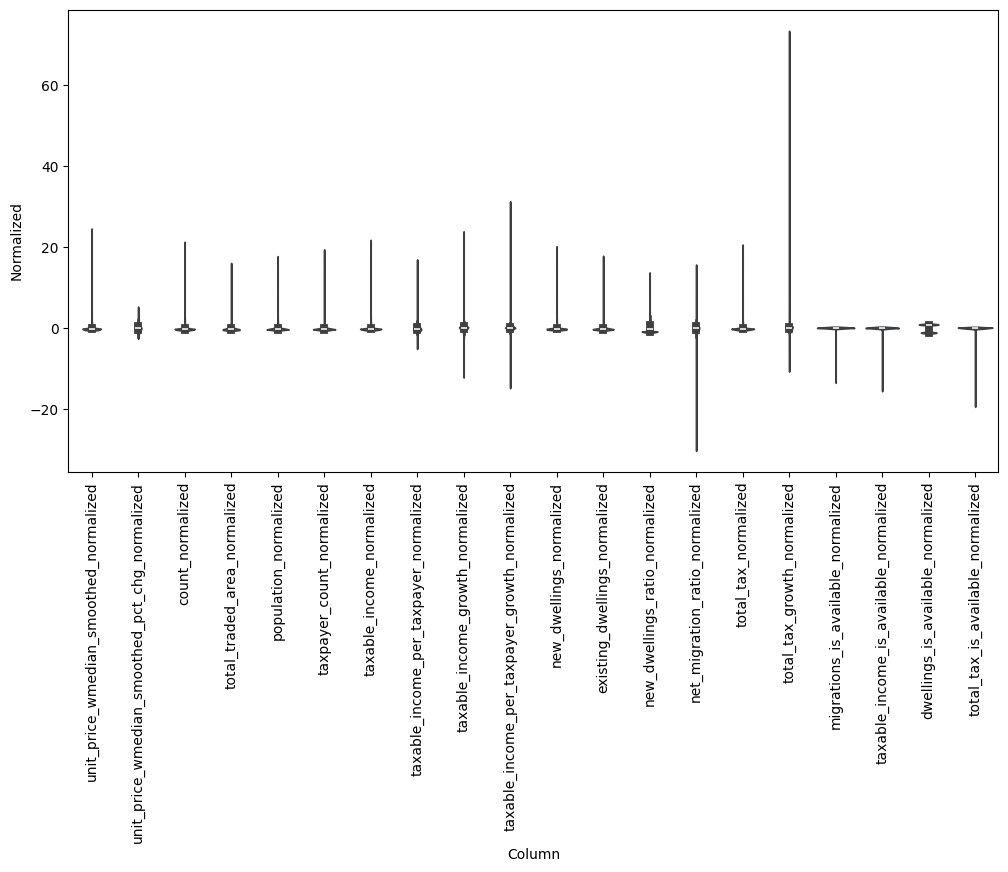

In [14]:
df_std = df[columns_normalized].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df[columns_normalized].keys(), rotation=90)

In [15]:
# Will yearly normalized columns be better?
# If average net migration higher for factor area X over area Y in the same year, I would think it would have higher return
# Compared to normalizing over all years. That also gives us access to future years which is undesirable

columns_normalized_yearly = [f"{col}_normalized_yearly" for col in columns]
for col in columns:
    df[f"{col}_normalized_yearly"] = df.groupby("year")[col].transform(
        lambda x: (x - x.mean()) / x.std()
    )

# To account for years where the data is not available and all the values are zero. In those situations, the normalized values will be NaN.
df = df.fillna(0)

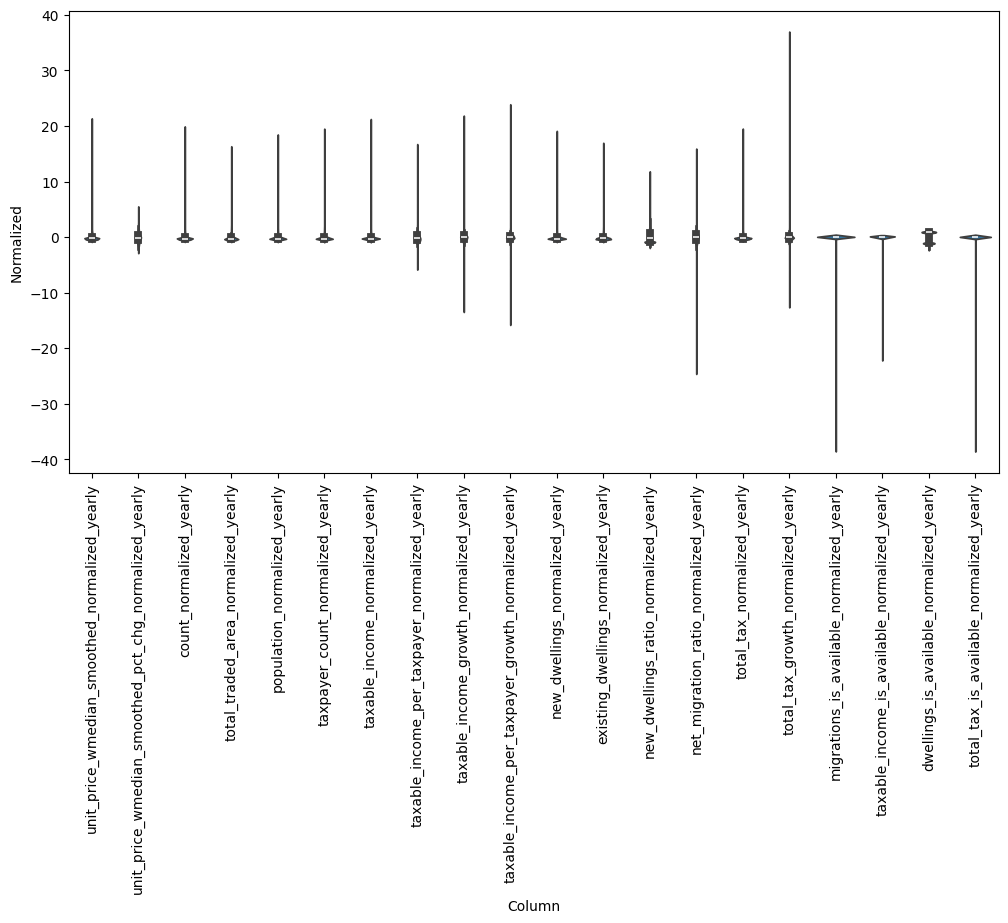

In [16]:
df_std = df[columns_normalized_yearly].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df[columns_normalized_yearly].keys(), rotation=90)

In [17]:
feature_columns = [metric_pct_chg] + columns_normalized_yearly + ["migrations_is_available", "taxable_income_is_available", "dwellings_is_available"]

time_series_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    feature_columns=feature_columns,
    shift=years_ahead
)

time_series_dataset_transformed = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    feature_columns=feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    shift=years_ahead
)

for i, sampleX in enumerate(time_series_dataset):
    print(
        i,
        sampleX["window"].shape,
        sampleX["target"].shape,
        sampleX["target"].values,
        sampleX["weight"].values,
    )
    if i == 3:
        break


for i, sampleY in enumerate(time_series_dataset_transformed):
    print(
        i,
        sampleY["window"].shape,
        sampleY["target"].shape,
        sampleY["target"],
        sampleY["weight"],
    )
    if i == 3:
        break

0 (0, 24) (1,) [-0.27696705] [1.41302792]
1 (0, 24) (1,) [-1.05336126] [1.0329277]
2 (0, 24) (1,) [-1.05940568] [1.00501074]
3 (0, 24) (1,) [-0.93155212] [1.00572656]
0 torch.Size([5, 24]) torch.Size([1]) tensor([-0.2770]) tensor([1.4130])
1 torch.Size([5, 24]) torch.Size([1]) tensor([-1.0534]) tensor([1.0329])
2 torch.Size([5, 24]) torch.Size([1]) tensor([-1.0594]) tensor([1.0050])
3 torch.Size([5, 24]) torch.Size([1]) tensor([-0.9316]) tensor([1.0057])


In [18]:
BATCH_SIZE = 256

In [19]:
train_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)
eval_dataset = JapanRETimeSeriesDataset(
    df,
    eval_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19182 entries, 0 to 19181
Data columns (total 65 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   unit_price_wmedian_smoothed_pct_chg                    19182 non-null  float64
 1   unit_price_wmedian_smoothed                            19182 non-null  float64
 2   year                                                   19182 non-null  int64  
 3   years_since_crisis                                     19182 non-null  int64  
 4   count                                                  19182 non-null  float64
 5   total_traded_area                                      19182 non-null  float64
 6   population                                             19182 non-null  float64
 7   taxpayer_count                                         19182 non-null  float64
 8   taxable_income                                

### Building the Transformer Model

In [21]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [22]:
n_features = len(feature_columns)
d_model = 256
d_hid = 256
nlayers = 8
nhead = 8
dropout = 0
enc_dropout = 0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    enc_dropout=enc_dropout,
    device=device,
)
model = model.to(device)


In [23]:
%%timeit

model.eval()

mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)
        
        print("Loss:", loss.item())

        break

torch.Size([256, 5, 24]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.0855014324188232
torch.Size([256, 5, 24]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.0855014324188232
torch.Size([256, 5, 24]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.0855014324188232
torch.Size([256, 5, 24]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.0855014324188232
torch.Size([256, 5, 24]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.0855014324188232
torch.Size([256, 5, 24]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.0855014324188232
torch.Size([256, 5, 24]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.0855014324188232
torch.Size([256, 5, 24]) torch.Size([256, 5]) torch.Size([256,

In [24]:
# Write a pretraining loop to go over all datasets and pretrain on that
# Use early stopping and regularization so you don't have to worry about overfitting
# Write the required parameters and processing functions for all the datasets and put them all in a dictionary

def extract_transformer_encoder_state_dict(state_dict):
    transformer_state_dict = {}
    for key, value in state_dict.items():
        if "transformer_encoder" in key:
            transformer_state_dict[key] = value
    return transformer_state_dict

# loaded_state_dict = extract_transformer_encoder_state_dict(torch.load("../../weights/jena_climate.pt"))
# model.load_state_dict(loaded_state_dict, strict=False)


In [25]:
learning_rate = 1e-4 # 3e-4
weight_decay = 1 # 1
num_epochs = 200

In [26]:
num_training_steps = num_epochs * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = get_scheduler(
    "constant",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [27]:
# progress_bar = tqdm(range(num_training_steps))
progress_bar = None

for epoch in range(num_epochs):
    train_loss, train_r2_score = train(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)
    
    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
    print(f"Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")

# progress_bar.close()

Epoch: 0
Train Loss: 4.2923, Eval Loss: 4.0329
Train R^2: -0.0535, Eval R^2: 0.0101
Epoch: 1
Train Loss: 3.9086, Eval Loss: 3.4113
Train R^2: 0.0379, Eval R^2: 0.1635
Epoch: 2
Train Loss: 3.5569, Eval Loss: 2.7205
Train R^2: 0.1244, Eval R^2: 0.3331
Epoch: 3
Train Loss: 3.3438, Eval Loss: 2.3711
Train R^2: 0.1767, Eval R^2: 0.4200
Epoch: 4
Train Loss: 3.1490, Eval Loss: 2.1773
Train R^2: 0.2249, Eval R^2: 0.4676
Epoch: 5
Train Loss: 2.8874, Eval Loss: 2.0378
Train R^2: 0.2894, Eval R^2: 0.5023
Epoch: 6
Train Loss: 2.6821, Eval Loss: 1.9744
Train R^2: 0.3397, Eval R^2: 0.5180
Epoch: 7
Train Loss: 2.4824, Eval Loss: 1.9255
Train R^2: 0.3889, Eval R^2: 0.5302
Epoch: 8
Train Loss: 2.3449, Eval Loss: 1.8821
Train R^2: 0.4229, Eval R^2: 0.5409
Epoch: 9
Train Loss: 2.2417, Eval Loss: 1.8524
Train R^2: 0.4482, Eval R^2: 0.5484
Epoch: 10
Train Loss: 2.2051, Eval Loss: 1.8161
Train R^2: 0.4574, Eval R^2: 0.5573
Epoch: 11
Train Loss: 2.1359, Eval Loss: 1.7941
Train R^2: 0.4744, Eval R^2: 0.5625
E

KeyboardInterrupt: 

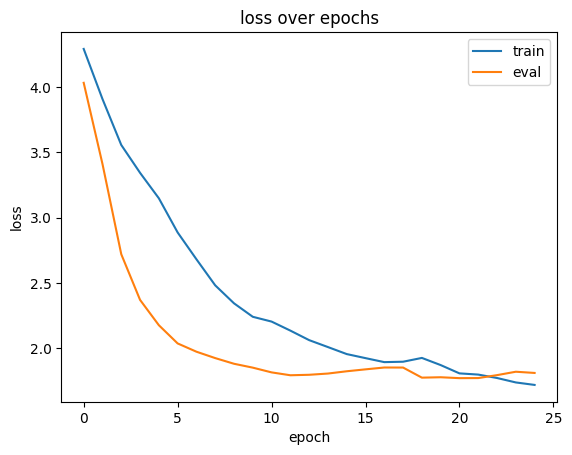

In [28]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

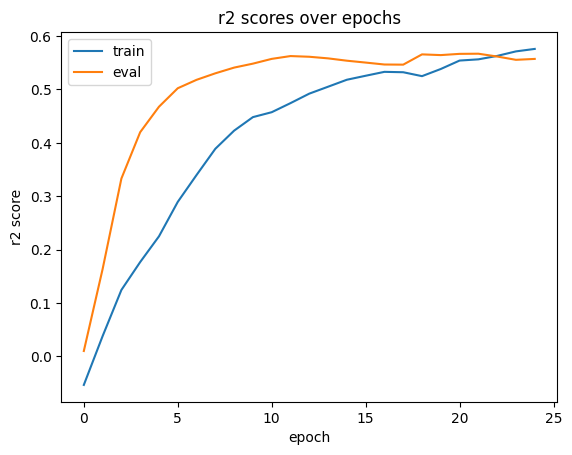

In [29]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()

In [32]:
# untrained model
loss, epoch_r2_score = evaluate(model, eval_dataloader, device=device)
print(f"Eval loss: {loss:.4f}")
print(f"Eval R2: {epoch_r2_score:.4f}")

Eval loss: 1.8422
Eval R2: 0.5511


In [32]:
# untrained model
loss, epoch_r2_score = evaluate(model, eval_dataloader, device=device)
print(f"Eval loss: {loss:.4f}")
print(f"Eval R2: {epoch_r2_score:.4f}")

Eval loss: 3.4521
Eval R2: 0.1688


### Pretraining and transfer gameplan

Within my time series model, I have the Transformer Encoder and the Positional Encoder. 
Once the model is done training, I will take the weights and save it to a file.
Then, I will load up the new model with this file.



In [103]:
test_year = 2021

presentation_df = df[df["area_code"].astype(int) // 1000 == 13]
presentation_df = presentation_df[presentation_df["year"] == test_year]
presentation_dataset = TimeSeriesDataset(
    df,
    presentation_df,
    feature_columns=feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)
presentation_dataloader = None

In [106]:
next(iter(presentation_dataloader))['window'].shape

torch.Size([49, 5, 14])

In [109]:
tokyo_dataset = next(iter(presentation_dataloader))
model.eval()
tokyo_output = model(tokyo_dataset['window'].to(torch.float32).to(device), tokyo_dataset['mask'].to(torch.float32).to(device))

In [110]:
tokyo_output

tensor([[ 0.0130],
        [-0.0186],
        [ 0.0277],
        [ 0.0216],
        [ 0.0877],
        [ 0.0506],
        [ 0.0254],
        [ 0.0862],
        [-0.0248],
        [-0.0092],
        [-0.1615],
        [-0.0008],
        [-0.2429],
        [-0.0291],
        [-0.0184],
        [-0.0267],
        [ 0.0206],
        [ 0.0577],
        [ 0.0117],
        [ 0.0127],
        [ 0.0254],
        [ 0.0156],
        [ 0.0252],
        [-0.0175],
        [ 0.0059],
        [-0.0571],
        [ 0.0357],
        [-0.0107],
        [-0.0207],
        [ 0.0368],
        [ 0.0526],
        [ 0.0167],
        [-0.1445],
        [ 0.0624],
        [ 0.0102],
        [-0.0105],
        [-0.0181],
        [-0.0953],
        [ 0.0091],
        [ 0.0136],
        [ 0.0164],
        [ 0.0693],
        [ 0.0277],
        [-0.0114],
        [ 0.0668],
        [ 0.0488],
        [ 0.0630],
        [-0.0585],
        [ 0.0442]], device='mps:0', grad_fn=<LinearBackward0>)

### Important Questions:
1. What is the optimal error?
2. What is the human level error?
3. How much better or worse is the model compared to human level error?

My assumption is that optimal error is zero %, and human level error is close to that. 
But it is likely that the human level error is considerably worse.

### The High Variance Problem

The model is overfitting right now